In [2]:


import pandas as pd
from prophet import Prophet
import numpy as np
import holidays
from prophet.diagnostics import cross_validation
import pandas as pd
import numpy as np
from datetime import date
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [14]:
df = pd.read_csv('partners-table.csv')
df = df.drop('month', axis=1)
df = df.drop('Unnamed: 4', axis=1)
df = df[(df['merchant_name'] == "Burger King")]
df = df.drop('merchant_name', axis=1)
df = df.reset_index(drop=True)
df = df.rename(columns={"day": "ds", "cashback":"y"})
df['ds'] = pd.to_datetime(df['ds'])
df['day_of_week'] = df['ds'].dt.dayofweek

In [15]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
print(df_holidays)

           ds                      holiday
0  2022-01-01            New Year Holidays
1  2022-01-02            New Year Holidays
2  2022-01-03            New Year Holidays
3  2022-01-04            New Year Holidays
4  2022-01-05            New Year Holidays
5  2022-01-06            New Year Holidays
6  2022-01-07                Christmas Day
7  2022-01-08            New Year Holidays
8  2022-02-23    Fatherland Defender's Day
9  2022-03-08    International Women's Day
10 2022-05-01  Holiday of Spring and Labor
11 2022-05-09                  Victory Day
12 2022-06-12                   Russia Day
13 2022-11-04                    Unity Day
14 2023-01-01            New Year Holidays
15 2023-01-02            New Year Holidays
16 2023-01-03            New Year Holidays
17 2023-01-04            New Year Holidays
18 2023-01-05            New Year Holidays
19 2023-01-06            New Year Holidays
20 2023-01-07                Christmas Day
21 2023-01-08            New Year Holidays
22 2023-02-

In [16]:
# Кол-во дней, которые надо отрезать и предсказать
predictions = 30

In [17]:
# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df

In [18]:
dif_days = int((pd.to_datetime(df["ds"].max()) - pd.to_datetime(df["ds"].min())).days) // 2
print(dif_days)

174


In [19]:
# Покрутим разные комбинации гиперпараметров
import itertools
import numpy as np
import pandas as pd

param_grid = {
    'changepoint_prior_scale': [0.25, 0.05, 0.1], ## по умолчанию 0.05, попробуем увеличить и уменьшить в два раза
    'seasonality_prior_scale': [5.0, 10.0, 20.0], ## по умолчанию 10.0, попробуем увеличить и уменьшить в два раза
    'holidays_prior_scale': [5.0, 10.0, 20.0], ## по умолчанию 10.0, попробуем увеличить и уменьшить в два раза
}

# Создаем все комбинации параметров
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Сюда будем складывать метрику MAPE

# Крутим кроссвалидацию со всеми комбинациями параметров
for params in all_params:
    m = Prophet(**params, holidays=df_holidays, daily_seasonality="auto", weekly_seasonality="auto", yearly_seasonality="auto")
    m.add_regressor('day_of_week')
    m.fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial=f'{dif_days} days', period=f'{dif_days//6} days', horizon = f'{dif_days//3 } days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1) ## тут окно для подсчета метрики 1, чтобы метрика считалась по всему горизонту
    mapes.append(df_p['mape'].values[0])

# Смотрим на результаты с разными параметрами
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/bzwkdpmq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/yxsx0qi1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=939', 'data', 'file=/tmp/tmprkqccgj4/bzwkdpmq.json', 'init=/tmp/tmprkqccgj4/yxsx0qi1.json', 'output', 'file=/tmp/tmprkqccgj4/prophet_model1y5fctb4/prophet_model-20240224153546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutof

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.25                      5.0                   5.0   
1                      0.25                      5.0                  10.0   
2                      0.25                      5.0                  20.0   
3                      0.25                     10.0                   5.0   
4                      0.25                     10.0                  10.0   
5                      0.25                     10.0                  20.0   
6                      0.25                     20.0                   5.0   
7                      0.25                     20.0                  10.0   
8                      0.25                     20.0                  20.0   
9                      0.05                      5.0                   5.0   
10                     0.05                      5.0                  10.0   
11                     0.05                      5.0            

In [20]:
# Отображаем лучшие параметры
best_params = all_params[np.argmin(mapes)]
print(best_params)
print(best_params["changepoint_prior_scale"])

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0}
0.05


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/74wdnfgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/48rfqog3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75557', 'data', 'file=/tmp/tmprkqccgj4/74wdnfgj.json', 'init=/tmp/tmprkqccgj4/48rfqog3.json', 'output', 'file=/tmp/tmprkqccgj4/prophet_modelm_x6s1ku/prophet_model-20240224153628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


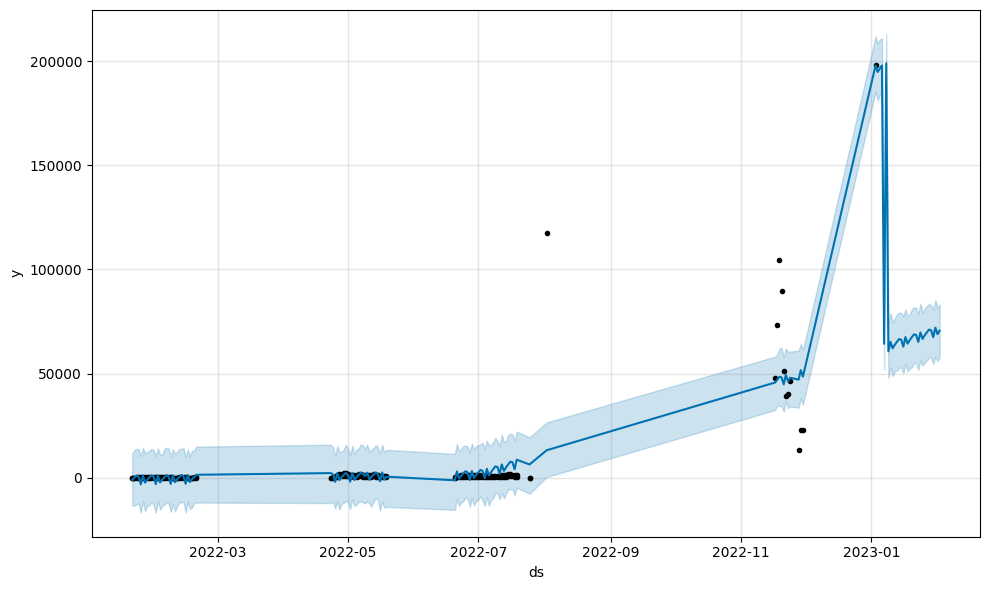

In [21]:
m = Prophet(holidays=df_holidays, daily_seasonality="auto", weekly_seasonality="auto", yearly_seasonality="auto",
            changepoint_prior_scale=best_params["changepoint_prior_scale"], seasonality_prior_scale=best_params["seasonality_prior_scale"], holidays_prior_scale=best_params["holidays_prior_scale"])
m.add_regressor('day_of_week')
m.fit(train_df)
future = train_df[['ds']].copy()
future = m.make_future_dataframe(30)
future['day_of_week'] = future['ds'].dt.dayofweek
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig1.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/c3ttghq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/2ncu0ney.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29492', 'data', 'file=/tmp/tmprkqccgj4/c3ttghq0.json', 'init=/tmp/tmprkqccgj4/2ncu0ney.json', 'output', 'file=/tmp/tmprkqccgj4/prophet_modelymgcm0vr/prophet_model-20240224162536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


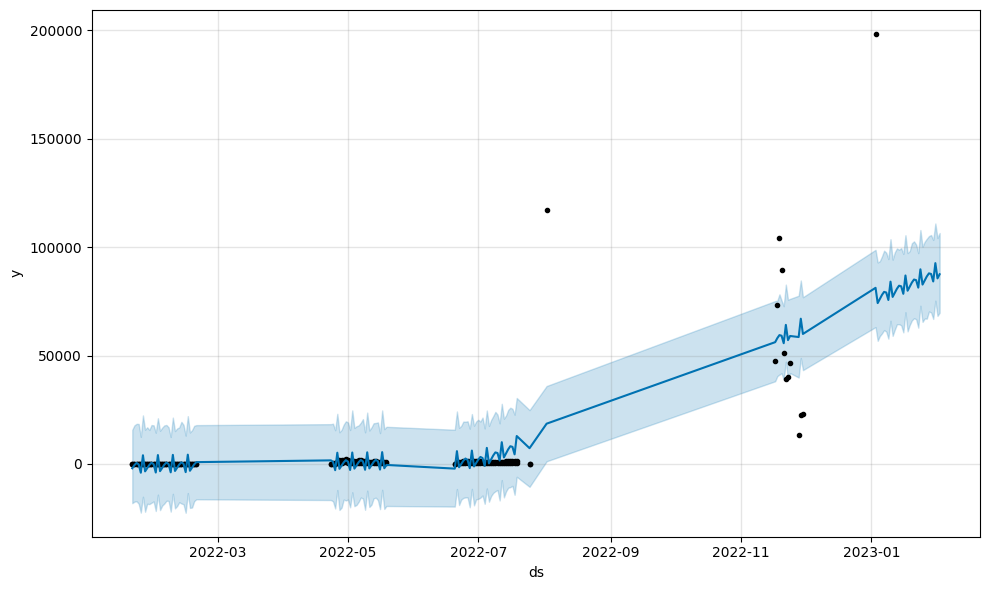

In [23]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig1.show()

In [31]:
df = pd.read_csv('Новая таблица - Merch_CB_hack.csv')
df = df.drop('month', axis=1)
df = df.drop('Unnamed: 4', axis=1)
df = df[(df['merchant_name'] == "Burger King")]
print(df)
df = df.drop('merchant_name', axis=1)
df = df.reset_index(drop=True)
df = df.rename(columns={"day": "ds", "cashback":"y"})
df['ds'] = pd.to_datetime(df['ds'])
df['day_of_week'] = df['ds'].dt.dayofweek

      merchant_name                 day   cashback
125     Burger King  2022-01-20 0:00:00       5.56
126     Burger King  2022-01-21 0:00:00      23.72
127     Burger King  2022-01-22 0:00:00      51.45
128     Burger King  2022-01-23 0:00:00      54.27
129     Burger King  2022-01-24 0:00:00      36.58
...             ...                 ...        ...
21303   Burger King  2022-11-24 0:00:00   46391.30
21304   Burger King  2022-11-28 0:00:00   13408.33
21305   Burger King  2022-11-29 0:00:00   22790.86
21306   Burger King  2022-11-30 0:00:00   22967.54
25326   Burger King  2023-01-03 0:00:00  198321.62

[102 rows x 3 columns]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/_df97ikf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprkqccgj4/4zskfuv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80048', 'data', 'file=/tmp/tmprkqccgj4/_df97ikf.json', 'init=/tmp/tmprkqccgj4/4zskfuv_.json', 'output', 'file=/tmp/tmprkqccgj4/prophet_model959uivrz/prophet_model-20240224163547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


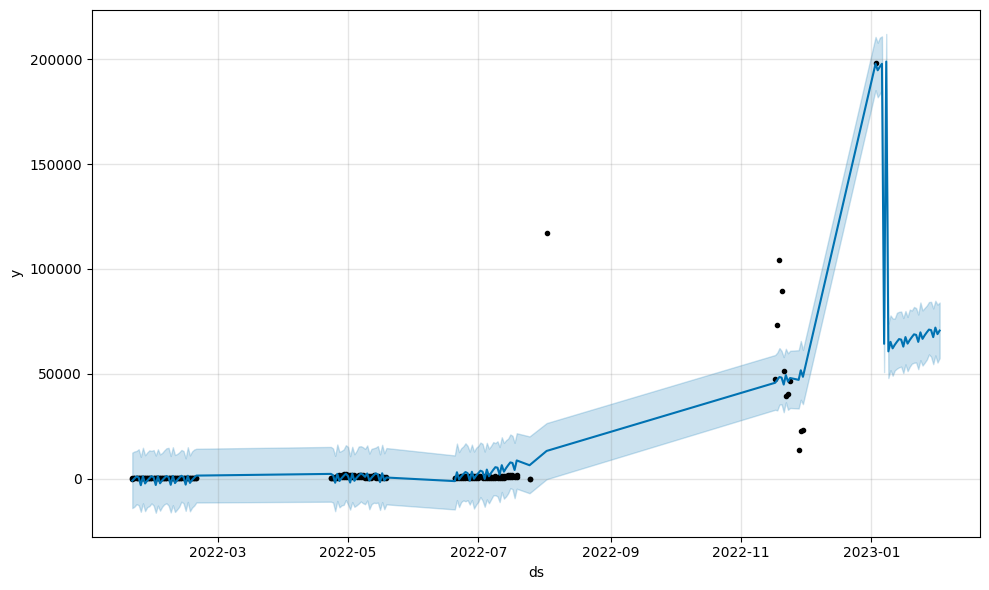

In [32]:
m = Prophet(holidays=df_holidays, daily_seasonality="auto", weekly_seasonality="auto", yearly_seasonality="auto",
            changepoint_prior_scale=best_params["changepoint_prior_scale"], seasonality_prior_scale=best_params["seasonality_prior_scale"], holidays_prior_scale=best_params["holidays_prior_scale"])
m.add_regressor('day_of_week')
m.fit(train_df)
future = train_df[['ds']].copy()
future = m.make_future_dataframe(30)
future['day_of_week'] = future['ds'].dt.dayofweek
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig1.show()